# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper


helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

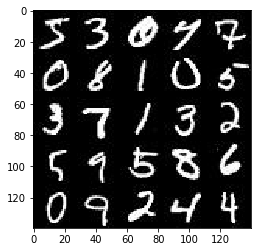

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

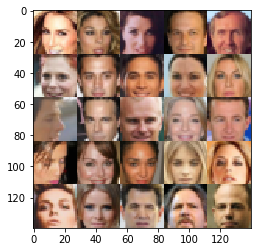

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import pickle as pkl

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\thienan092\Anaconda3\envs\ds-project\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def dc_discriminator(x, reuse=False, alpha=0.2, keep_prob=0.8):
    # Input layer is 28x28x3
    x0 = tf.image.resize_images(images=x, size=(32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, align_corners=False)
    # 32x32x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.nn.relu(x1) # tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.relu(bn2) # tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.relu(bn3) # tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits

def discriminator(x, reuse=False, n_units=128, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.reshape(tf.layers.dense(h1, 1, activation=None), [-1, 1])
        out = tf.reshape(tf.sigmoid(logits), [-1, 1])
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(dc_discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def dc_generator(z, out_channel_dim, is_train=True, alpha=0.2, training=True, keep_prob=0.6):
    with tf.variable_scope('generator', reuse=False if is_train== True else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 32x32x3 now
        
        out0 = tf.tanh(logits)
    
    out = tf.image.resize_images(images=out0, size=(28, 28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, align_corners=False)
    # 28x28x3
    
    return out

def generator(z, out_channel_dim, is_train=True, n_units=128, alpha=0.01):
    with tf.variable_scope('generator', reuse=False if is_train== True else True):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, 28*28*out_channel_dim, activation=None)
        out = tf.reshape(tf.tanh(logits), [-1, 28, 28, out_channel_dim])
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(dc_generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def dc_model_loss(inputs_real, input_z, out_channel_dim, alpha=0.2, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Build the model
    g_model = dc_generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    # g_model is the generator output
    d_model_real, d_logits_real = dc_discriminator(inputs_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = dc_discriminator(g_model, reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss

def model_loss(inputs_real, input_z, out_channel_dim, n_units=128, alpha=0.01, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True, n_units=n_units, alpha=alpha)
    # g_model is the generator output
    d_model_real, d_logits_real = discriminator(inputs_real, reuse=False, n_units=n_units, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=n_units, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(dc_model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def dc_model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    print("Hehe")
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(dc_model_opt, tf)

Hehe
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def dc_show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    print ("z_dim: {}".format(z_dim))
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        dc_generator(input_z, out_channel_dim, False, alpha=0.2),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    print ("z_dim: {}".format(z_dim))
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, n_units=256, alpha=0.01),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def guess_it(sess, n_images, input_z, out_channel_dim, force_print=True):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    g_model = dc_generator(input_z, out_channel_dim, False, alpha=0.2)
    probs = sess.run(
        dc_discriminator(g_model, reuse=True, alpha=0.2),
        feed_dict={input_z: example_z})
    
    right_prob = np.mean(probs[0] < 0.5)
    
    if force_print:
        print ("The probability of guessing correctly on {} fake images: {}".format(n_images, right_prob))
        
    return right_prob

class GAN:
    def __init__(self, z_dim, data_shape, out_channel_dim, n_units=128, alpha=0.2, beta1=0.5):
        image_width, image_height, image_channels = data_shape[1:]
        
        self.inputs_real, self.inputs_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        self.d_loss, self.g_loss = model_loss(self.inputs_real, self.inputs_z, out_channel_dim, n_units=n_units, alpha=alpha, smooth=0.9)
        self.d_train_opt, self.g_train_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1=beta1)
        
class DCGAN:
    def __init__(self, z_dim, data_shape, out_channel_dim, alpha=0.2, beta1=0.5):
        image_width, image_height, image_channels = data_shape[1:]
        
        self.inputs_real, self.inputs_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        self.d_loss, self.g_loss = dc_model_loss(self.inputs_real, self.inputs_z, out_channel_dim, alpha=alpha, smooth=0.9)
        self.d_train_opt, self.g_train_opt = dc_model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1=beta1)
        
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode, n_units=128, alpha=0.01):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    save_file_path = './checkpoints/generator.ckpt'
    
    # out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    out_channel_dim = data_shape[-1]
    
    # Create the network
    net = DCGAN(z_dim, data_shape, out_channel_dim, alpha=0.2, beta1=beta1)
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    losses = []
    # Only save generator variables
    saver = tf.train.Saver(var_list=g_vars)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2 # normalize the input
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                
                _ = sess.run(net.d_train_opt, feed_dict={net.inputs_real: batch_images, net.inputs_z: batch_z, net.learning_rate: lr})
                _ = sess.run(net.d_train_opt, feed_dict={net.inputs_real: batch_images, net.inputs_z: batch_z, net.learning_rate: lr})
                _ = sess.run(net.d_train_opt, feed_dict={net.inputs_real: batch_images, net.inputs_z: batch_z, net.learning_rate: lr})


                _ = sess.run(net.g_train_opt, feed_dict={net.inputs_z: batch_z, net.learning_rate: lr, net.inputs_real: batch_images})
                _ = sess.run(net.g_train_opt, feed_dict={net.inputs_z: batch_z, net.learning_rate: lr, net.inputs_real: batch_images})
                _ = sess.run(net.g_train_opt, feed_dict={net.inputs_z: batch_z, net.learning_rate: lr, net.inputs_real: batch_images})
                _ = sess.run(net.g_train_opt, feed_dict={net.inputs_z: batch_z, net.learning_rate: lr, net.inputs_real: batch_images})
                
                if steps % print_every == 0:
                    # Get the losses and print them out
                    train_loss_d = sess.run(net.d_loss, {net.inputs_z: batch_z, net.inputs_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    dc_show_generator_output(sess, 4, net.inputs_z, out_channel_dim, data_image_mode)
                    # Guess it
                    prob_to_save = guess_it(sess, 100, net.inputs_z, out_channel_dim)
                    if prob_to_save > 0.42 and prob_to_save < 0.58:
                        print("Saving the network...")
                        saver.save(sess, save_file_path)
                        print("Done!")
                    
        if os.path.isfile(save_file_path):
            saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
        
        dc_show_generator_output(sess, 25, net.inputs_z, out_channel_dim, data_image_mode)
        # Guess it
        guess_it(sess, 100, net.inputs_z, out_channel_dim)
        
        
        

        
        # fig, ax = pyplot.subplots()
        # losses = np.array(losses)
        # pyplot.plot(losses.T[0], label='Discriminator')
        # pyplot.plot(losses.T[1], label='Generator')
        # pyplot.title("Training Losses")
        # pyplot.legend()

        

### MNIST
    Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Hehe
Epoch 1/2... Discriminator Loss: 2.7623... Generator Loss: 0.1387
Epoch 1/2... Discriminator Loss: 1.4679... Generator Loss: 0.5585
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 1.6348... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.7832
z_dim: 100


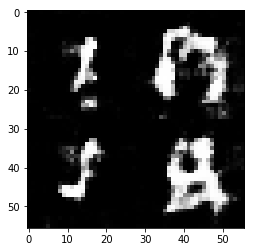

The probability of guessing correctly on 100 fake images: 0.84
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.5253
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.8116
z_dim: 100


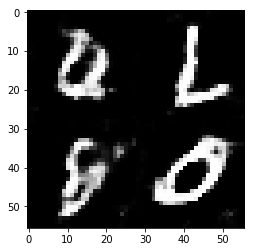

The probability of guessing correctly on 100 fake images: 0.77
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.9870
z_dim: 100


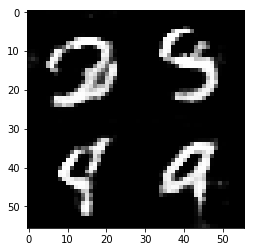

The probability of guessing correctly on 100 fake images: 0.95
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 0.9682
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.4533
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.5080
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 1.3471
z_dim: 100


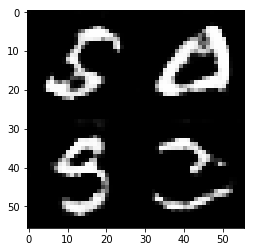

The probability of guessing correctly on 100 fake images: 0.97
Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 2.1253
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.4158
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 1.7168
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 1.5740
Epoch 2/2... Discriminator Loss: 0.5204... Generator Loss: 1.5419
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.1664
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.1991
z_dim: 100


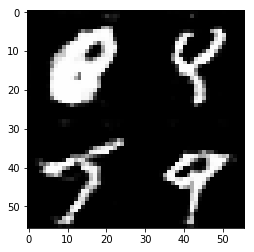

The probability of guessing correctly on 100 fake images: 0.95
Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.4691
Epoch 2/2... Discriminator Loss: 2.4057... Generator Loss: 0.2337
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 1.3776
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 1.5060
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.2058
z_dim: 100


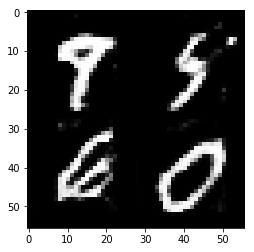

The probability of guessing correctly on 100 fake images: 0.85
Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 2.0900
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 1.6289
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.7643
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 3.4441... Generator Loss: 0.0752
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 1.6051
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.2913
z_dim: 100


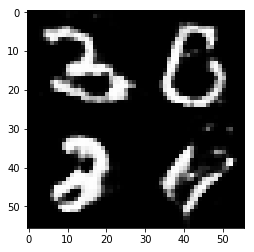

The probability of guessing correctly on 100 fake images: 0.86
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 1.5308
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 1.5658
Epoch 2/2... Discriminator Loss: 0.4576... Generator Loss: 1.5394
Epoch 2/2... Discriminator Loss: 0.3924... Generator Loss: 1.9148
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 2.1343
Epoch 2/2... Discriminator Loss: 0.3127... Generator Loss: 2.2005
Epoch 2/2... Discriminator Loss: 0.3142... Generator Loss: 1.7014
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 1.4456
Epoch 2/2... Discriminator Loss: 0.2797... Generator Loss: 2.1040
Epoch 2/2... Discriminator Loss: 0.3145... Generator Loss: 2.1826
z_dim: 100


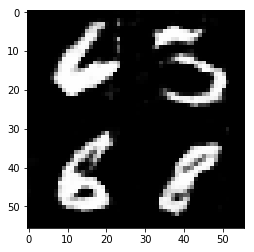

The probability of guessing correctly on 100 fake images: 0.99
Epoch 2/2... Discriminator Loss: 0.4976... Generator Loss: 2.2372
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.4285
Epoch 2/2... Discriminator Loss: 0.2684... Generator Loss: 2.2129
Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.4627
Epoch 2/2... Discriminator Loss: 0.2345... Generator Loss: 2.7676
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 2.1141
Epoch 2/2... Discriminator Loss: 0.2740... Generator Loss: 2.0090
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 1.9135
Epoch 2/2... Discriminator Loss: 0.2405... Generator Loss: 2.1298
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.6549
z_dim: 100


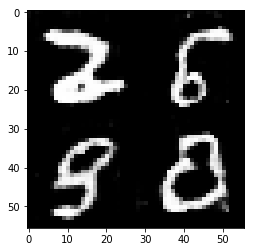

The probability of guessing correctly on 100 fake images: 0.78
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 0.2561... Generator Loss: 2.7810
Epoch 2/2... Discriminator Loss: 0.3132... Generator Loss: 2.1933
z_dim: 100


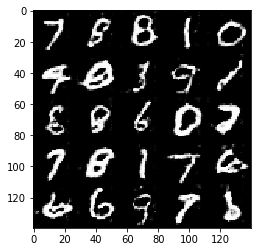

The probability of guessing correctly on 100 fake images: 1.0


In [15]:
learning_rate = 0.0002
batch_size = 128
beta1 = 0.5
z_dim = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0957... Generator Loss: 0.2320
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.7991... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4777
z_dim: 100


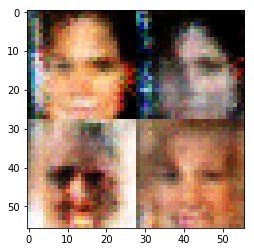

The probability of guessing correctly on 100 fake images: 0.41
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.9449... Generator Loss: 0.2807
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.3406
Epoch 1/1... Discriminator Loss: 1.7626... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.6921... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.3746
z_dim: 100


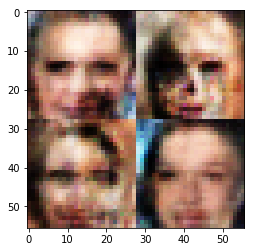

The probability of guessing correctly on 100 fake images: 0.21
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 0.3837
z_dim: 100


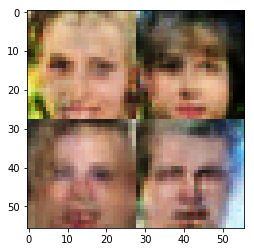

The probability of guessing correctly on 100 fake images: 0.43
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.7258... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.3707
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.9324... Generator Loss: 0.2536
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 1.7473... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.3422
z_dim: 100


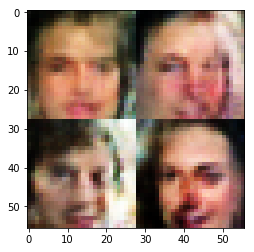

The probability of guessing correctly on 100 fake images: 0.41
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.6261... Generator Loss: 0.3258
z_dim: 100


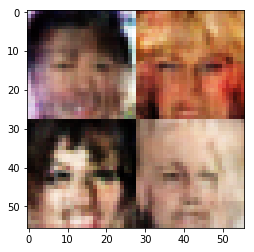

The probability of guessing correctly on 100 fake images: 0.56
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.3630
Epoch 1/1... Discriminator Loss: 1.7644... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 2.1810... Generator Loss: 0.1951
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.3307
z_dim: 100


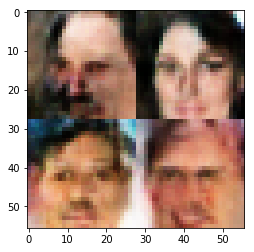

The probability of guessing correctly on 100 fake images: 0.53
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.8316... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.7532... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.6537... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.3774
z_dim: 100


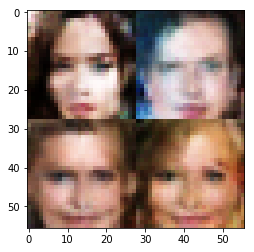

The probability of guessing correctly on 100 fake images: 0.63
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.3977
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.4019
z_dim: 100


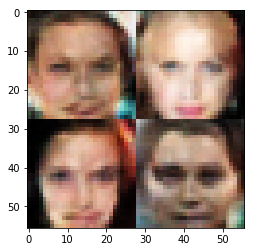

The probability of guessing correctly on 100 fake images: 0.57
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.7188... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.4407
z_dim: 100


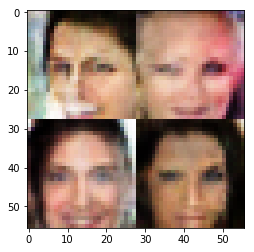

The probability of guessing correctly on 100 fake images: 0.56
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.7497... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 1.8826... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.3907
z_dim: 100


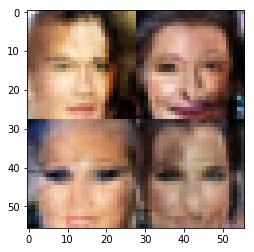

The probability of guessing correctly on 100 fake images: 0.64
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.9203... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 2.4654... Generator Loss: 0.1407
Epoch 1/1... Discriminator Loss: 2.2634... Generator Loss: 0.2092
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.4305
z_dim: 100


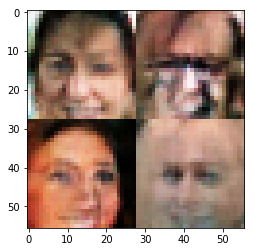

The probability of guessing correctly on 100 fake images: 0.79
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.8088... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 2.3089... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.8672... Generator Loss: 0.2230
z_dim: 100


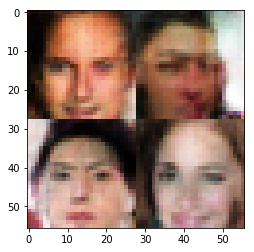

The probability of guessing correctly on 100 fake images: 0.57
Saving the network...
Done!
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 2.0490... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 2.3627... Generator Loss: 0.2080
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5726
z_dim: 100


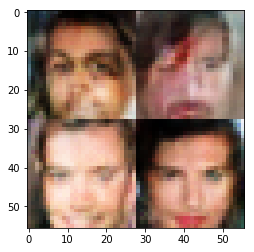

The probability of guessing correctly on 100 fake images: 0.81
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5549
z_dim: 100


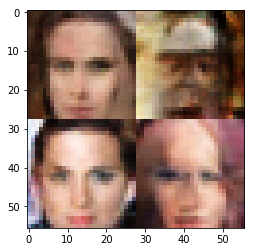

The probability of guessing correctly on 100 fake images: 0.85
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 0.3481
Epoch 1/1... Discriminator Loss: 2.0080... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.9902... Generator Loss: 0.2403
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.7935
z_dim: 100


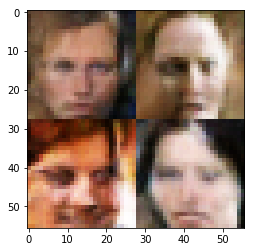

The probability of guessing correctly on 100 fake images: 0.86
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 2.1927... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 1.5328
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.4779
z_dim: 100


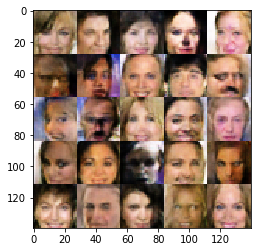

The probability of guessing correctly on 100 fake images: 0.62


In [13]:
learning_rate = 0.0002
batch_size = 128
beta1 = 0.5
z_dim = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.